In [27]:
import torch
from tqdm import tqdm
import argparse

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

import objgraph

import time
import utils
from result_tracking import ThinkerwiseResultTracker

from dn3.configuratron import ExperimentConfig
from dn3.data.dataset import Thinker
from dn3.trainable.processes import StandardClassification

from dn3_ext import BENDRClassification, LinearHeadBENDR
from matplotlib import pyplot as plt

In [2]:
from dotmap import DotMap

In [3]:
args = DotMap()

In [4]:
args.model = "BENDR"
args.ds_config = "configs/downstream.yml"
args.metrics_config = "configs/metrics.yml"
args.subject_specific = False
args.mdl = False
args.freeze_encoder = False
args.random_init = False
args.multi_gpu = True
args.num_workers = 4
args.results_filename = None

In [5]:
args.ds_config

'configs/downstream.yml'

In [6]:
experiment = ExperimentConfig(args.ds_config)

Adding additional configuration entries: dict_keys(['train_params', 'lr', 'folds'])
Configuratron found 1 datasets.


In [7]:
data = experiment.datasets["mmidb"]

In [8]:
ds_name, ds = list(experiment.datasets.items())[0]

In [9]:
added_metrics, retain_best, _ = utils.get_ds_added_metrics(ds_name, args.metrics_config)

In [10]:
gen =  utils.get_lmoso_iterator(ds_name, ds)

Scanning data/datasets/eegmmidb. If there are a lot of files, this may take a while...: 100%|██████████| 4/4 [00:00<00:00, 13.23it/s, extension=.gdf]


Creating dataset of 315 Preloaded Epoched recordings from 105 people.


Loading Physionet MMIDB: 100%|██████████| 105/105 [00:11<00:00,  9.03person/s]


>> Physionet MMIDB | DSID: None | 105 people | 4408 trials | 90 channels | 1536 samples/trial | 256Hz | 0 transforms
Constructed 1 channel maps
Used by 315 recordings:
EEG (original(new)): Fc5.(FC5) Fc3.(FC3) Fc1.(FC1) Fcz.(FCZ) Fc2.(FC2) Fc4.(FC4) Fc6.(FC6) C5..(C5) C3..(C3) C1..(C1) Cz..(CZ) C2..(C2) C4..(C4) C6..(C6) Cp5.(CP5) Cp3.(CP3) Cp1.(CP1) Cpz.(CPZ) Cp2.(CP2) Cp4.(CP4) Cp6.(CP6) Fp1.(FP1) Fpz.(FPZ) Fp2.(FP2) Af7.(AF7) Af3.(AF3) Afz.(AFZ) Af4.(AF4) Af8.(AF8) F7..(F7) F5..(F5) F3..(F3) F1..(F1) Fz..(FZ) F2..(F2) F4..(F4) F6..(F6) F8..(F8) Ft7.(FT7) Ft8.(FT8) T7..(T7) T8..(T8) T9..(T9) T10.(T10) Tp7.(TP7) Tp8.(TP8) P7..(P7) P5..(P5) P3..(P3) P1..(P1) Pz..(PZ) P2..(P2) P4..(P4) P6..(P6) P8..(P8) Po7.(PO7) Po3.(PO3) Poz.(POZ) Po4.(PO4) Po8.(PO8) O1..(O1) Oz..(OZ) O2..(O2) Iz..(IZ) 
EOG (original(new)): 
REF (original(new)): 
EXTRA (original(new)): 
Heuristically Assigned: Fc5.(FC5)  Fc3.(FC3)  Fc1.(FC1)  Fcz.(FCZ)  Fc2.(FC2)  Fc4.(FC4)  Fc6.(FC6)  C5..(C5)  C3..(C3)  C1..(C1)  Cz.

In [11]:
training, validation, test = next(gen)

Training:   >> Physionet MMIDB | DSID: None | 63 people | 2646 trials | 20 channels | 1536 samples/trial | 256Hz | 1 transforms
Validation: >> Physionet MMIDB | DSID: None | 21 people | 880 trials | 20 channels | 1536 samples/trial | 256Hz | 1 transforms
Test:       >> Physionet MMIDB | DSID: None | 21 people | 882 trials | 20 channels | 1536 samples/trial | 256Hz | 1 transforms


In [13]:
#model = BENDRClassification.from_dataset(training, multi_gpu = True)
model = BENDRClassification.from_dataset(training)
model.load_pretrained_modules(experiment.encoder_weights, experiment.context_weights,
                                              freeze_encoder=args.freeze_encoder)

Creating BENDRClassification using: 20 channels x 1536 samples at 256Hz | 2 targets
Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 16 encoded samples/trial


In [14]:
x, y = training.to_numpy()

Loading Batches: 100%|██████████| 42/42 [00:04<00:00,  9.77it/s]


In [34]:
experiment.encoder_weights = 'contextualizer_BENDR.pt'
experiment.context_weights = 'encoder_BENDR.pt'

In [35]:
model = BENDRClassification(targets=2, samples=1536, channels=20)
model.load_pretrained_modules(experiment.encoder_weights, experiment.context_weights, freeze_encoder=args.freeze_encoder)
process = StandardClassification(model, metrics=added_metrics, cuda="cuda")

process.train(False)

Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 16 encoded samples/trial


In [37]:
device = torch.device('cuda')

In [38]:
torch.cuda.empty_cache()

In [39]:
import numpy as np

In [41]:
preds = np.empty(len(y), dtype=int)
for i in tqdm(range(len(preds))):
    inputs = torch.Tensor(x[None, i]).to(device)
    preds[i] = torch.nn.Softmax(dim=1)(process.forward(inputs, None)).argmax(1).item()
    del inputs

100%|██████████| 2646/2646 [00:29<00:00, 89.76it/s]


In [47]:
inputs = torch.Tensor(x[None, 0]).to(device)

In [61]:
process.forward(inputs, None)

tensor([[0.2836, 0.2253]], device='cuda:0', grad_fn=<AddmmBackward0>)

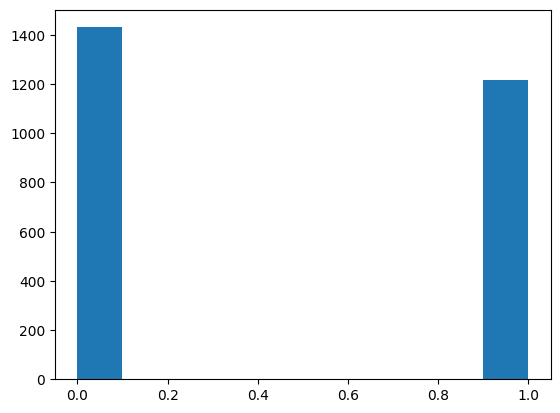

In [42]:
plt.hist(preds)
plt.show()

In [46]:
y.shape

(2646,)

In [44]:
training.get_targets()

array([0, 1, 0, ..., 1, 0, 1])